In [1]:
import numpy as np
import torch
import sys
import os
from torchvision import models
from mftma.manifold_analysis_correlation import manifold_analysis_corr
from mftma.utils.make_manifold_data import make_manifold_data
from mftma.utils.activation_extractor import extractor
from mftma.utils.analyze_pytorch import analyze
import getpass
import argparse
import pandas as pd
from neural_manifold_utils import CFAR100_fake_dataset_mftma , save_dict
from datetime import datetime
print('__cuda available ',torch.cuda.is_available())
print('__Python VERSION:', sys.version)
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
#import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, models
import copy 

__cuda available  False
__Python VERSION: 3.6.10 (default, Jun  9 2020, 18:36:16) 
[GCC 8.3.0]
__CUDNN VERSION: 7605
__Number CUDA Devices: 0


In [2]:
user=getpass.getuser()
print(user)
if user=='eghbalhosseini':
    save_dir='/Users/eghbalhosseini/MyData/neural_manifolds/network_training_on_synthetic/'
    data_dir='/Users/eghbalhosseini/MyData/neural_manifolds/synthetic_datasets/'
    
elif user=='ehoseini':
    save_dir='/om/user/ehoseini/MyData/neural_manifolds/network_training_on_synthetic/'
    data_dir='/om/user/ehoseini/MyData/neural_manifolds/synthetic_datasets/'
train_dir=os.path.join(save_dir,'train_VGG16_synthdata_tree_nclass_50_n_exm_1000')


ehoseini


In [3]:
datafile=os.path.join(train_dir,'mftma_epoch_1_layer_16')
epoch_dat=pd.read_pickle(datafile)
#activations_cell=epoch_dat['activations_cell']

In [5]:
epoch_dat.keys()

dict_keys(['mftma_results', 'train_spec', 'train_accuracy', 'train_success', 'epoch', 'layer_num'])

In [125]:
hier_layer_names=[list(activations.keys()) for activations in activations_cell]
layer_n=[x[layer_num] for x in hier_layer_names]


In [126]:

layer_activ_cell=[{layer_n[idx]:x[layer_n[idx]]} for idx, x in enumerate(activations_cell)]
del activations_cell

In [127]:
for hier_id, activ_hier in enumerate(layer_activ_cell):
    for layer, data in activ_hier.items():
        X = [d.reshape(d.shape[0], -1).T for d in data]
        N = X[0].shape[0]
        if N > 5000:
            print("Projecting {}".format(layer))
            M = np.random.randn(5000, N)
            M /= np.sqrt(np.sum(M*M, axis=1, keepdims=True))
            X = [np.matmul(M, d) for d in X]
        activ_hier[layer] = X
    layer_activ_cell[hier_id]=activ_hier

Projecting layer_8_Conv2d
Projecting layer_8_Conv2d
Projecting layer_8_Conv2d


In [134]:
mftmas_cell=[]
for hier_id, activ_hier in enumerate(layer_activ_cell):
    data_ = {'capacities': [],
             'radii': [],
             'dimensions': [],
             'correlations':[],
             'layer':[],
            'n_hier_class':[],
            'hierarchy':hier_id}
    capacities = []
    radii = []
    dimensions = []
    correlations = []
    data_['layer']=layer_n[hier_id]
    data_['n_hier_class']=len(activ_hier[layer_n[hier_id]])
    for k, X, in activ_hier.items():
        print(k)
    # Analyze each layer's activations
        try:
            a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)

            # Compute the mean values
            a = 1/np.mean(1/a)
            r = np.mean(r)
            d = np.mean(d)
            print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(k, a, r, d, r0))
        except:
            a=np.nan
            r=np.nan
            d=np.nan
            r0=np.nan
        # Store for later
        capacities.append(a)
        radii.append(r)
        dimensions.append(d)
        correlations.append(r0)
    # combine the results 
    data_['capacities']=capacities
    data_['radii']=radii
    data_['dimensions']=dimensions
    data_['correlations']=correlations
    mftmas_cell.append(data_)

layer_8_Conv2d
layer_8_Conv2d capacity: 0.165138, radius 1.089527, dimension 10.410941, correlation 0.037931
layer_8_Conv2d
layer_8_Conv2d capacity: 0.115513, radius 1.347441, dimension 12.942582, correlation 0.111000
layer_8_Conv2d


In [135]:
mftmas_cell

[{'capacities': [0.1651376707382891],
  'radii': [1.089526983449012],
  'dimensions': [10.410940807081829],
  'correlations': [0.03793126558198901],
  'layer': 'layer_8_Conv2d',
  'n_hier_class': 50,
  'hierarchy': 0},
 {'capacities': [0.11551345819288716],
  'radii': [1.3474409894042978],
  'dimensions': [12.942582203967927],
  'correlations': [0.11099992791875377],
  'layer': 'layer_8_Conv2d',
  'n_hier_class': 10,
  'hierarchy': 1},
 {'capacities': [nan],
  'radii': [nan],
  'dimensions': [nan],
  'correlations': [nan],
  'layer': 'layer_8_Conv2d',
  'n_hier_class': 2,
  'hierarchy': 2}]

In [103]:
len(activ_hier[layer_n[hier_id]])
#int(np.unique([len(activ_hier[x]) for x in data_['layers']]))

2

In [68]:
for hier_id, activ_hier in enumerate(activations_cell):
    layer_names=list(activ_hier.keys())
    for layer, data, in activ_hier.items():
        X = [d.reshape(d.shape[0], -1).T for d in data]
        # Get the number of features in the flattened data
        N = X[0].shape[0]
        # If N is greater than 5000, do the random projection to 5000 features
        if N > 5000:
            print("Projecting {}".format(layer))
        #    M = np.random.randn(5000, N)
        #    M /= np.sqrt(np.sum(M*M, axis=1, keepdims=True))
        #    X = [np.matmul(M, d) for d in X]
        #activ_hier[layer] = X
    #activations_cell[hier_id]=activ_hier

In [14]:
mftmas_cell=[]
for hier_id, activ_hier in enumerate(activations_cell):
    data_ = {'capacities': [],
             'radii': [],
             'dimensions': [],
             'correlations':[],
             'layers':[],
            'n_class':[],
            'hierarchy':hier_id}
    capacities = []
    radii = []
    dimensions = []
    correlations = []
    data_['layers']=activ_hier.keys()
    data_['hier_n_class']=int(np.unique([len(activ_hier[x]) for x in data_['layers']]))
    for k, X, in activ_hier.items():
    # Analyze each layer's activations
        a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)
    
        # Compute the mean values
        a = 1/np.mean(1/a)
        r = np.mean(r)
        d = np.mean(d)
        print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(k, a, r, d, r0))
        # Store for later
        capacities.append(a)
        radii.append(r)
        dimensions.append(d)
        correlations.append(r0)
    # combine the results 
    data_['capacities']=capacities
    data_['radii']=radii
    data_['dimensions']=dimensions
    data_['correlations']=correlations

    mftmas_cell.append(data_)

    

layer_0_Input capacity: 0.211601, radius 0.959192, dimension 8.947558, correlation 0.039704
layer_1_Conv2d capacity: 0.211371, radius 0.967394, dimension 8.921848, correlation 0.040846
layer_3_Conv2d capacity: 0.205813, radius 0.969026, dimension 9.061046, correlation 0.040062
layer_6_Conv2d capacity: 0.168343, radius 1.078327, dimension 10.334135, correlation 0.037059
layer_8_Conv2d capacity: 0.166536, radius 1.088031, dimension 10.376245, correlation 0.038048
layer_11_Conv2d capacity: 0.144555, radius 1.176096, dimension 11.323170, correlation 0.038661


KeyboardInterrupt: 

In [63]:
X[0].shape

(3072, 100)

In [57]:
mfmta_data_ = {'mftma_results': mftmas_cell,
             'train_spec': epoch_dat['train_spec'],
             'train_accuracy': epoch_dat['train_accuracy'],
             'train_success': epoch_dat['train_success'],
             'epoch': epoch_dat['epoch']}


In [ ]:
[activations.keys() for activations in activations_cell]

In [15]:
layer_names=list(activationenumerate))
layer=layer_names[1];
data=activations[layer]
X = [d.reshape(d.shape[0], -1).T for d in data]
N = X[0].shape[0]
# If N is greater than 5000, do the random projection to 5000 features
if N > 5000:
    print("Projecting {}".format(layer))
    M = np.random.randn(5000, N)
    M /= np.sqrt(np.sum(M * M, axis=1, keepdims=True))
    X = [np.matmul(M, d) for d in X]
data=X
capacities = []
radii = []
dimensions = []
correlations = []
a, r, d, r0, K = manifold_analysis_corr(data, 0, 300, n_reps=1)
a = 1 / np.mean(1 / a)
r = np.mean(r)
d = np.mean(d)
print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(layer, a, r, d, r0))


Projecting layer_1_Conv2d
layer_1_Conv2d capacity: 0.134586, radius 0.704864, dimension 21.363340, correlation 0.034933


In [18]:
result_save_path = save_dir + 'mftma_VGG16_synthdata_' + train_dataset.structure + '_nclass_' + str(
        int(train_dataset.n_class)) + '_n_exm_' + str(int(train_dataset.exm_per_class)) + str(1)

NameError: name 'train_dataset' is not defined

# First

In [3]:
datafile='synth_partition_nobj_50000_nclass_50_nfeat_3072_beta_0.01_sigma_1.50_norm_1.mat'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = CFAR100_fake_dataset_mftma(data_dir=os.path.join(data_dir, datafile))
sampled_classes = 50
examples_per_class = 100
data = make_manifold_data(dataset, sampled_classes, examples_per_class, seed=0)
model_save_path=save_dir+'VGG16_synthdata_'+dataset.structure+'_nclass_'+str(int(dataset.n_class))+'_n_exm_'+str(int(dataset.exm_per_class))
model = models.vgg16(num_classes=dataset.n_class)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model = model.eval()
activations = extractor(model, data, layer_types=['Conv2d', 'Linear'])
list(activations.keys())
for layer, data, in activations.items():
    X = [d.reshape(d.shape[0], -1).T for d in data]
    # Get the number of features in the flattened data
    N = X[0].shape[0]
    # If N is greater than 5000, do the random projection to 5000 features
    if N > 5000:
        print("Projecting {}".format(layer))
        M = np.random.randn(5000, N)
        M /= np.sqrt(np.sum(M * M, axis=1, keepdims=True))
        X = [np.matmul(M, d) for d in X]
    activations[layer] = X
capacities = []
radii = []
dimensions = []
correlations = []
for k, X, in activations.items():
    # Analyze each layer's activations
    a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)
    # Compute the mean values
    a = 1 / np.mean(1 / a)
    r = np.mean(r)
    d = np.mean(d)
    print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(k, a, r, d, r0))

    # Store for later
    capacities.append(a)
    radii.append(r)
    dimensions.append(d)
    correlations.append(r0)
names = list(activations.keys())
names = [n.split('_')[1] + ' ' + n.split('_')[2] for n in names]
# save the results:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
results_file = os.path.join(save_dir,'mftma_'+model_save_path+'_'+current_time)
data_1 = {'capacities': capacities,
             'radii': radii,
             'dimensions': dimensions,
             'correlations': correlations,
             'names': names,
             'analyze_exm_per_class': examples_per_class,
             'analyze_n_class': sampled_classes
             }

result_save_path=save_dir+'mftma_VGG16_synthdata_'+dataset.structure+'_nclass_'+str(int(dataset.n_class))+'_n_exm_'+str(int(dataset.exm_per_class))+'_'+current_time
save_dict(data_1, result_save_path)


<HDF5 dataset "data": shape (100000,), type "<f8"> is not a matlab type
<HDF5 dataset "ir": shape (100000,), type "<u8"> is not a matlab type
<HDF5 dataset "jc": shape (50051,), type "<u8"> is not a matlab type
data type not supported: graph, uint32
Projecting layer_1_Conv2d
Projecting layer_3_Conv2d
Projecting layer_6_Conv2d
Projecting layer_8_Conv2d
Projecting layer_11_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d

layer_0_Input capacity: 0.141250, radius 0.695877, dimension 20.883590, correlation 0.026355
layer_1_Conv2d capacity: 0.134201, radius 0.702846, dimension 21.445646, correlation 0.034618
layer_3_Conv2d capacity: 0.119807, radius 0.726960, dimension 23.284775, correlation 0.035750
layer_6_Conv2d capacity: 0.116491, radius 0.740667, dimension 23.351559, correlation 0.056953
layer_8_Conv2d capacity: 0.114075, radius 0.754188, dimension 23.404018, correlation 0.069422
layer_11_Conv2

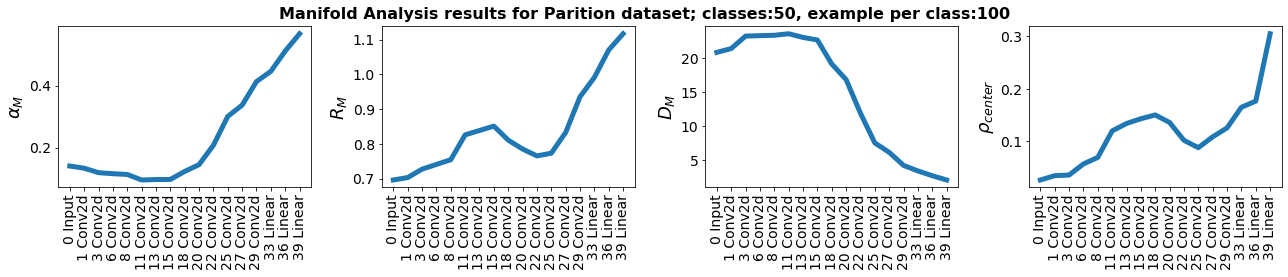

In [19]:
capacities=data_1['capacities']
radii=data_1['radii']
dimensions=data_1['dimensions']
correlations=data_1['correlations']
names=data_1['names']

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
plt.suptitle('Manifold Analysis results for Parition dataset; classes:'+ str(data_1['analyze_n_class'])+', example per class:'+str(data_1['analyze_exm_per_class']),
            fontsize=16,fontweight='bold')
axes[0].plot(capacities, linewidth=5)
axes[1].plot(radii, linewidth=5)
axes[2].plot(dimensions, linewidth=5)
axes[3].plot(correlations, linewidth=5)

axes[0].set_ylabel(r'$\alpha_M$', fontsize=18)
axes[1].set_ylabel(r'$R_M$', fontsize=18)
axes[2].set_ylabel(r'$D_M$', fontsize=18)
axes[3].set_ylabel(r'$\rho_{center}$', fontsize=18)

for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

#plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Second 

In [4]:
datafile='synth_tree_nobj_50000_nclass_50_nfeat_3072_beta_0.01_sigma_1.50_norm_1.mat'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = CFAR100_fake_dataset_mftma(data_dir=os.path.join(data_dir, datafile))
sampled_classes = 50
examples_per_class = 100
data = make_manifold_data(dataset, sampled_classes, examples_per_class, seed=0)
model_save_path=save_dir+'VGG16_synthdata_'+dataset.structure+'_nclass_'+str(int(dataset.n_class))+'_n_exm_'+str(int(dataset.exm_per_class))
model = models.vgg16(num_classes=dataset.n_class)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model = model.eval()
activations = extractor(model, data, layer_types=['Conv2d', 'Linear'])
list(activations.keys())
for layer, data, in activations.items():
    X = [d.reshape(d.shape[0], -1).T for d in data]
    # Get the number of features in the flattened data
    N = X[0].shape[0]
    # If N is greater than 5000, do the random projection to 5000 features
    if N > 5000:
        print("Projecting {}".format(layer))
        M = np.random.randn(5000, N)
        M /= np.sqrt(np.sum(M * M, axis=1, keepdims=True))
        X = [np.matmul(M, d) for d in X]
    activations[layer] = X
capacities = []
radii = []
dimensions = []
correlations = []
for k, X, in activations.items():
    # Analyze each layer's activations
    a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)
    # Compute the mean values
    a = 1 / np.mean(1 / a)
    r = np.mean(r)
    d = np.mean(d)
    print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(k, a, r, d, r0))

    # Store for later
    capacities.append(a)
    radii.append(r)
    dimensions.append(d)
    correlations.append(r0)
names = list(activations.keys())
names = [n.split('_')[1] + ' ' + n.split('_')[2] for n in names]
# save the results:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
results_file = os.path.join(save_dir,'mftma_'+model_save_path+'_'+current_time)
data_2 = {'capacities': capacities,
             'radii': radii,
             'dimensions': dimensions,
             'correlations': correlations,
             'names': names,
             'analyze_exm_per_class': examples_per_class,
             'analyze_n_class': sampled_classes
             }

result_save_path=save_dir+'mftma_VGG16_synthdata_'+dataset.structure+'_nclass_'+str(int(dataset.n_class))+'_n_exm_'+str(int(dataset.exm_per_class))+'_'+current_time
save_dict(data_2, result_save_path)


<HDF5 dataset "data": shape (100124,), type "<f8"> is not a matlab type
<HDF5 dataset "ir": shape (100124,), type "<u8"> is not a matlab type
<HDF5 dataset "jc": shape (50064,), type "<u8"> is not a matlab type
data type not supported: graph, uint32
data type not supported: graph, uint32
Projecting layer_1_Conv2d
Projecting layer_3_Conv2d
Projecting layer_6_Conv2d
Projecting layer_8_Conv2d
Projecting layer_11_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
layer_0_Input capacity: 0.102709, radius 0.756305, dimension 26.038174, correlation 0.042738
layer_1_Conv2d capacity: 0.101766, radius 0.760243, dimension 25.789936, correlation 0.050019
layer_3_Conv2d capacity: 0.092023, radius 0.784479, dimension 27.644909, correlation 0.053492
layer_6_Conv2d capacity: 0.085289, radius 0.822211, dimension 28.337742, correlation 0.073646
layer_8_Conv2d capacity: 0.080588, radius 0.835992, dimension 29.28874

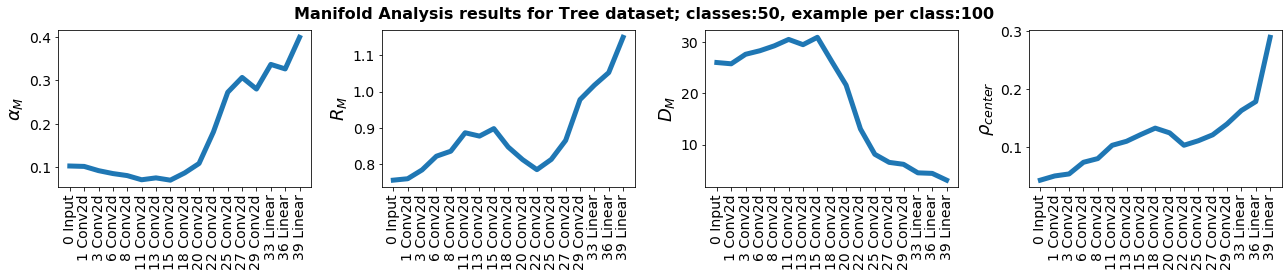

In [21]:
data=data_2
capacities=data['capacities']
radii=data['radii']
dimensions=data['dimensions']
correlations=data['correlations']
names=data['names']

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
plt.suptitle('Manifold Analysis results for Tree dataset; classes:'+ str(data['analyze_n_class'])+', example per class:'+str(data['analyze_exm_per_class']),
            fontsize=16,fontweight='bold')
axes[0].plot(capacities, linewidth=5)
axes[1].plot(radii, linewidth=5)
axes[2].plot(dimensions, linewidth=5)
axes[3].plot(correlations, linewidth=5)

axes[0].set_ylabel(r'$\alpha_M$', fontsize=18)
axes[1].set_ylabel(r'$R_M$', fontsize=18)
axes[2].set_ylabel(r'$D_M$', fontsize=18)
axes[3].set_ylabel(r'$\rho_{center}$', fontsize=18)

for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

#plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Third

In [5]:
datafile='synth_partition_nobj_100000_nclass_100_nfeat_3072_beta_0.01_sigma_1.50_norm_1.mat'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = CFAR100_fake_dataset_mftma(data_dir=os.path.join(data_dir, datafile))
sampled_classes = 100
examples_per_class = 200
data = make_manifold_data(dataset, sampled_classes, examples_per_class, seed=0)
model_save_path=save_dir+'VGG16_synthdata_'+dataset.structure+'_nclass_'+str(int(dataset.n_class))+'_n_exm_'+str(int(dataset.exm_per_class))
model = models.vgg16(num_classes=dataset.n_class)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model = model.eval()
activations = extractor(model, data, layer_types=['Conv2d', 'Linear'])
list(activations.keys())
for layer, data, in activations.items():
    X = [d.reshape(d.shape[0], -1).T for d in data]
    # Get the number of features in the flattened data
    N = X[0].shape[0]
    # If N is greater than 5000, do the random projection to 5000 features
    if N > 5000:
        print("Projecting {}".format(layer))
        M = np.random.randn(5000, N)
        M /= np.sqrt(np.sum(M * M, axis=1, keepdims=True))
        X = [np.matmul(M, d) for d in X]
    activations[layer] = X
capacities = []
radii = []
dimensions = []
correlations = []
for k, X, in activations.items():
    # Analyze each layer's activations
    a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)
    # Compute the mean values
    a = 1 / np.mean(1 / a)
    r = np.mean(r)
    d = np.mean(d)
    print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(k, a, r, d, r0))

    # Store for later
    capacities.append(a)
    radii.append(r)
    dimensions.append(d)
    correlations.append(r0)
names = list(activations.keys())
names = [n.split('_')[1] + ' ' + n.split('_')[2] for n in names]
# save the results:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
results_file = os.path.join(save_dir,'mftma_'+model_save_path+'_'+current_time)
data_3 = {'capacities': capacities,
             'radii': radii,
             'dimensions': dimensions,
             'correlations': correlations,
             'names': names,
             'analyze_exm_per_class': examples_per_class,
             'analyze_n_class': sampled_classes
             }

result_save_path=save_dir+'mftma_VGG16_synthdata_'+dataset.structure+'_nclass_'+str(int(dataset.n_class))+'_n_exm_'+str(int(dataset.exm_per_class))+'_'+current_time
save_dict(data_3, result_save_path)


<HDF5 dataset "data": shape (200000,), type "<f8"> is not a matlab type
<HDF5 dataset "ir": shape (200000,), type "<u8"> is not a matlab type
<HDF5 dataset "jc": shape (100101,), type "<u8"> is not a matlab type
data type not supported: graph, uint32
Projecting layer_1_Conv2d
Projecting layer_3_Conv2d
Projecting layer_6_Conv2d
Projecting layer_8_Conv2d
Projecting layer_11_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
layer_0_Input capacity: 0.111906, radius 0.635511, dimension 30.095164, correlation 0.021462
layer_1_Conv2d capacity: 0.106945, radius 0.647353, dimension 30.708133, correlation 0.028869
layer_3_Conv2d capacity: 0.095547, radius 0.663076, dimension 33.225380, correlation 0.031453
layer_6_Conv2d capacity: 0.087336, radius 0.687833, dimension 34.580784, correlation 0.049938
layer_8_Conv2d capacity: 0.077953, radius 0.714790, dimension 36.674349, correlation 0.056894
layer_11_Conv2

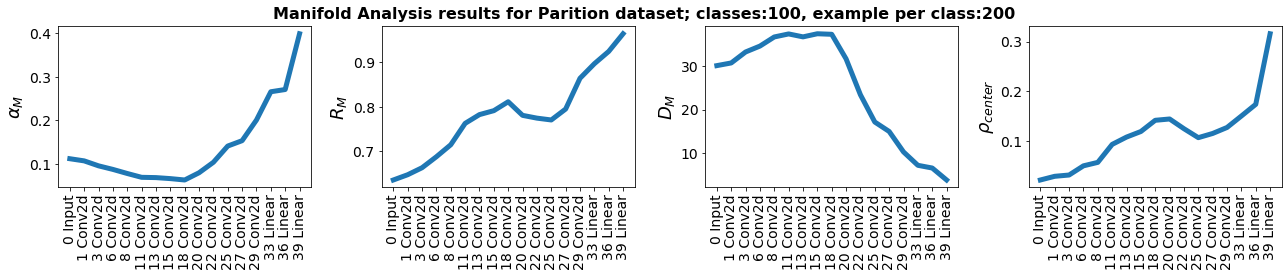

In [20]:
data=data_3
capacities=data['capacities']
radii=data['radii']
dimensions=data['dimensions']
correlations=data['correlations']
names=data['names']

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
plt.suptitle('Manifold Analysis results for Parition dataset; classes:'+ str(data['analyze_n_class'])+', example per class:'+str(data['analyze_exm_per_class']),
            fontsize=16,fontweight='bold')
axes[0].plot(capacities, linewidth=5)
axes[1].plot(radii, linewidth=5)
axes[2].plot(dimensions, linewidth=5)
axes[3].plot(correlations, linewidth=5)

axes[0].set_ylabel(r'$\alpha_M$', fontsize=18)
axes[1].set_ylabel(r'$R_M$', fontsize=18)
axes[2].set_ylabel(r'$D_M$', fontsize=18)
axes[3].set_ylabel(r'$\rho_{center}$', fontsize=18)

for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

#plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# forth : super class analysis 

In [92]:
datafile='synth_tree_nobj_50000_nclass_50_nfeat_3072_beta_0.01_sigma_1.50_norm_1.mat'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = CFAR100_fake_dataset_mftma(data_dir=os.path.join(data_dir, datafile))

<HDF5 dataset "data": shape (100124,), type "<f8"> is not a matlab type
<HDF5 dataset "ir": shape (100124,), type "<u8"> is not a matlab type
<HDF5 dataset "jc": shape (50064,), type "<u8"> is not a matlab type
data type not supported: graph, uint32
data type not supported: graph, uint32


In [83]:
num_hierarchy=len(dataset.vals.hierarchical_class_ids)
hier_classes=[x-1 for x in dataset.vals.hierarchical_class_ids]
hier_n_class=[int(max(x)+1) for x in hier_classes]
exm_per_class=10

In [115]:
hier_dat_mtmfa=[]
for idx, x in enumerate(hier_classes):
        dat_mfmta=[]
        dat_mfmta=copy.deepcopy(dataset)
        dat_mtmfa.target=hier_classes[idx]
        hier_dat_mtmfa.append(copy.deepcopy(dat_mtmfa));


In [118]:
hier_dat_mtmfa[3].target

IndexError: list index out of range

In [93]:
make_manifold_data([dataset.dat,dataset.target], 50, exm_per_class, seed=0)

AssertionError: Not enough examples per class in dataset

In [121]:
hier_sample_mtmfa= [make_manifold_data(x, hier_n_class[idx], exm_per_class, seed=0) for idx, x in enumerate(hier_dat_mtmfa)]

In [128]:
model_save_path=save_dir+'VGG16_synthdata_'+dataset.structure+'_nclass_'+str(int(dataset.n_class))+'_n_exm_'+str(int(dataset.exm_per_class))
model = models.vgg16(num_classes=dataset.n_class)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model = model.eval()

In [129]:
activations_cell = [extractor(model,x,layer_types=['Conv2d', 'Linear']) for x in hier_sample_mtmfa]

In [132]:
dataset.structure

'tree'

In [46]:
model_save_path=save_dir+'VGG16_synthdata_'+dataset.structure+'_nclass_'+str(int(dataset.n_class))+'_n_exm_'+str(int(dataset.exm_per_class))
model = models.vgg16(num_classes=dataset.n_class)
model.load_state_dict(torch.load(model_save_path, map_location=device))
model = model.to(device)
model = model.eval()
activations = extractor(model, data, layer_types=['Conv2d', 'Linear'])
list(activations.keys())
for layer, data, in activations.items():
    X = [d.reshape(d.shape[0], -1).T for d in data]
    # Get the number of features in the flattened data
    N = X[0].shape[0]
    # If N is greater than 5000, do the random projection to 5000 features
    if N > 5000:
        print("Projecting {}".format(layer))
        M = np.random.randn(5000, N)
        M /= np.sqrt(np.sum(M * M, axis=1, keepdims=True))
        X = [np.matmul(M, d) for d in X]
    activations[layer] = X
capacities = []
radii = []
dimensions = []
correlations = []
for k, X, in activations.items():
    # Analyze each layer's activations
    a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)
    # Compute the mean values
    a = 1 / np.mean(1 / a)
    r = np.mean(r)
    d = np.mean(d)
    print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(k, a, r, d, r0))

    # Store for later
    capacities.append(a)
    radii.append(r)
    dimensions.append(d)
    correlations.append(r0)
names = list(activations.keys())
names = [n.split('_')[1] + ' ' + n.split('_')[2] for n in names]
# save the results:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
results_file = os.path.join(save_dir,'mftma_'+model_save_path+'_'+current_time)
data_4 = {'capacities': capacities,
             'radii': radii,
             'dimensions': dimensions,
             'correlations': correlations,
             'names': names,
             'analyze_exm_per_class': examples_per_class,
             'analyze_n_class': sampled_classes
             }

result_save_path=save_dir+'mftma_VGG16_synthdata_'+dataset.structure+'_nclass_'+str(hier_n_class)+'_n_exm_'+str(int(dataset.exm_per_class))+'_'+current_time
save_dict(data_2, result_save_path)


Projecting layer_1_Conv2d
Projecting layer_3_Conv2d
Projecting layer_6_Conv2d
Projecting layer_8_Conv2d
Projecting layer_11_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d
layer_0_Input capacity: 0.031646, radius 0.849065, dimension 74.624999, correlation 0.112385
layer_1_Conv2d capacity: 0.032181, radius 0.864260, dimension 72.148690, correlation 0.112616
layer_3_Conv2d capacity: 0.029938, radius 0.881056, dimension 75.945329, correlation 0.114156
layer_6_Conv2d capacity: 0.030882, radius 0.913256, dimension 70.715433, correlation 0.126882
layer_8_Conv2d capacity: 0.028243, radius 0.930102, dimension 75.413132, correlation 0.136095
layer_11_Conv2d capacity: 0.031064, radius 0.933344, dimension 67.506751, correlation 0.150674
layer_13_Conv2d capacity: 0.033322, radius 0.929301, dimension 63.967174, correlation 0.149601
layer_15_Conv2d capacity: 0.035565, radius 0.901804, dimension 61.888895, c

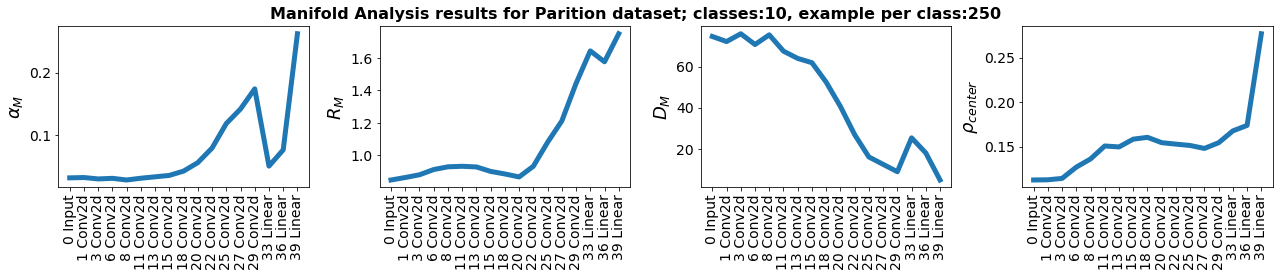

In [48]:
data=data_4
capacities=data['capacities']
radii=data['radii']
dimensions=data['dimensions']
correlations=data['correlations']
names=data['names']

fig, axes = plt.subplots(1, 4, figsize=(18, 4))
plt.suptitle('Manifold Analysis results for Parition dataset; classes:'+ str(data['analyze_n_class'])+', example per class:'+str(data['analyze_exm_per_class']),
            fontsize=16,fontweight='bold')
axes[0].plot(capacities, linewidth=5)
axes[1].plot(radii, linewidth=5)
axes[2].plot(dimensions, linewidth=5)
axes[3].plot(correlations, linewidth=5)

axes[0].set_ylabel(r'$\alpha_M$', fontsize=18)
axes[1].set_ylabel(r'$R_M$', fontsize=18)
axes[2].set_ylabel(r'$D_M$', fontsize=18)
axes[3].set_ylabel(r'$\rho_{center}$', fontsize=18)

for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

#plt.tight_layout()
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [47]:
data_4

{'capacities': [0.03164626042089437,
  0.03218086467346523,
  0.029937715021545908,
  0.030882008552401738,
  0.028242963767118746,
  0.031063870068930684,
  0.03332162435821455,
  0.035564760443297046,
  0.04246376463830018,
  0.055993618473981564,
  0.07929605321634856,
  0.11846760691952139,
  0.1417944559902163,
  0.1740418682851706,
  0.050448788543546154,
  0.07645373846891823,
  0.26213661813006417],
 'radii': [0.8490650909432087,
  0.8642600635874848,
  0.8810563303653842,
  0.9132564352050846,
  0.9301018924432564,
  0.9333441527355409,
  0.9293005567524437,
  0.9018043204324151,
  0.8861719347664325,
  0.867843326132447,
  0.9336182033172964,
  1.0807158395084822,
  1.212027216767887,
  1.4425576159073457,
  1.6429739650208177,
  1.57587764264419,
  1.7483415653615872],
 'dimensions': [74.62499921364585,
  72.14869016383624,
  75.94532934277136,
  70.71543263029605,
  75.4131324968425,
  67.50675059073752,
  63.9671738012701,
  61.888894835571286,
  52.44530800306897,
  40.64